In [ ]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import auc, f1_score, roc_curve


import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
data_dir = r'/content/drive/My Drive/CNS_Data'
%cd /content/drive/My\ Drive/CNS_Data
#!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/CNS_Data


In [ ]:
# Creating a empty dict, where I will save all parameters required for test data transformation

saved_dict = {}

In [ ]:
# Reading datasets
dfs = []
for i in range(1,5):
    path = '{0}/UNSW-NB15_{1}.csv'.format(data_dir,i)  # There are 4 input csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

In [ ]:
# This csv file contains names of all the features
df_col = pd.read_csv('{}/NUSW-NB15_features.csv'.format(data_dir), encoding='ISO-8859-1')

In [ ]:
# Making column names lower case, removing spaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

In [ ]:
# Renaming our dataframe with proper column names
all_data.columns = df_col['Name']

In [ ]:
# Saving useful info, later this will be used to transform raw test data
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()

In [ ]:
del df_col

In [ ]:
all_data.shape

(2540047, 49)

In [ ]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [ ]:
all_data[all_data['tcprtt'] != 0]['proto'].unique()

array(['tcp'], dtype=object)

In [ ]:
print([x for x in all_data['proto'].unique()])

['udp', 'arp', 'tcp', 'ospf', 'icmp', 'igmp', 'sctp', 'udt', 'sep', 'sun-nd', 'swipe', 'mobile', 'pim', 'rtp', 'ipnip', 'ip', 'ggp', 'st2', 'egp', 'cbt', 'emcon', 'nvp', 'igp', 'xnet', 'argus', 'bbn-rcc', 'chaos', 'pup', 'hmp', 'mux', 'dcn', 'prm', 'trunk-1', 'xns-idp', 'trunk-2', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'iso-tp4', 'netblt', 'mfe-nsp', 'merit-inp', '3pc', 'xtp', 'idpr', 'tp++', 'ddp', 'idpr-cmtp', 'ipv6', 'il', 'idrp', 'ipv6-frag', 'sdrp', 'ipv6-route', 'gre', 'rsvp', 'mhrp', 'bna', 'esp', 'i-nlsp', 'narp', 'ipv6-no', 'tlsp', 'skip', 'ipv6-opts', 'any', 'cftp', 'sat-expak', 'kryptolan', 'rvd', 'ippc', 'sat-mon', 'ipcv', 'visa', 'cpnx', 'cphb', 'wsn', 'pvp', 'br-sat-mon', 'wb-mon', 'wb-expak', 'iso-ip', 'secure-vmtp', 'vmtp', 'vines', 'ttp', 'nsfnet-igp', 'dgp', 'tcf', 'eigrp', 'sprite-rpc', 'larp', 'mtp', 'ax.25', 'ipip', 'micp', 'aes-sp3-d', 'encap', 'etherip', 'pri-enc', 'gmtp', 'pnni', 'ifmp', 'aris', 'qnx', 'a/n', 'scps', 'snp', 'ipcomp', 'compaq-peer', 'ipx-n-ip', 'vrrp

In [ ]:
all_data['stime'] == all_data['ltime']

0           True
1           True
2           True
3           True
4           True
           ...  
2540042    False
2540043    False
2540044    False
2540045    False
2540046    False
Length: 2540047, dtype: bool

In [ ]:
import datetime

timestamp_msec = 1421927414
timestamp_sec = timestamp_msec / 1000  # Convert to seconds
date_time = datetime.datetime.utcfromtimestamp(timestamp_sec)

print(date_time)

1970-01-17 10:58:47.414000


In [ ]:
all_data[all_data['label'] == 1].shape

(321283, 49)

In [ ]:
train, test = train_test_split(all_data, test_size=0.4, random_state=42, stratify=all_data['label'])

In [ ]:
all_data[all_data['label'] == 0].shape[0]/all_data.shape[0]

0.8735129704292873

In [ ]:
test[test['label'] == 0].shape[0]/test.shape[0]

0.8735131921745558

In [ ]:
train.shape, test.shape

((1524028, 49), (1016019, 49))

In [ ]:
columns_to_drop = ['attack_cat', 'srcip', 'dstip', 'sport', 'dsport']
train.drop(columns_to_drop, axis = 1, inplace = True)
test.drop(columns_to_drop, axis = 1, inplace = True)

In [ ]:
train['is_ftp_login'].mode()

0    0.0
Name: is_ftp_login, dtype: float64

In [ ]:
train['is_ftp_login'] = np.where(train['is_ftp_login']>1, 1, train['is_ftp_login'])
test['is_ftp_login'] = np.where(test['is_ftp_login'] > 1, 1, test['is_ftp_login'])

In [ ]:
train['ct_flw_http_mthd'].mode()

0    0.0
Name: ct_flw_http_mthd, dtype: float64

In [ ]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value = 0)
test['ct_flw_http_mthd'] = test.ct_flw_http_mthd.fillna(value = 0)

In [ ]:
train['is_ftp_login'] = (train.is_ftp_login.fillna(value=0)).astype(int)
test['is_ftp_login'] = (test.is_ftp_login.fillna(value=0)).astype(int)

In [ ]:
test.isnull().sum().sum()

0

In [ ]:
train['ct_ftp_cmd'].mode()

0     
Name: ct_ftp_cmd, dtype: object

In [ ]:
# Removing empty space and converting it to numerical
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)
test['ct_ftp_cmd'] = test['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

In [ ]:
all(train.columns == test.columns)

True

In [ ]:
train.shape, test.shape

((1524028, 44), (1016019, 44))

In [ ]:
# Categorical feature names
test.select_dtypes(exclude=np.number).columns

Index(['proto', 'state', 'service'], dtype='object', name='Name')

In [ ]:
# Numeric features names
train.select_dtypes(include=np.number).columns

Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload',
       'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object', name='Name')

In [ ]:
# Info for test data transformation
saved_dict['binary_col'] = ['is_sm_ips_ports', 'is_ftp_login']

In [ ]:
for col in 'is_sm_ips_ports', 'is_ftp_login':
    print(train[col].value_counts())
    print()

0    1521559
1       2469
Name: is_sm_ips_ports, dtype: int64

0    1497965
1      26063
Name: is_ftp_login, dtype: int64



In [ ]:
train['service'].isnull().sum()

0

In [ ]:
# removing all the "-" and replacing those with "None"
train['service'] = train['service'].apply(lambda x:"None" if x=="-" else x)
test['service'] = test['service'].apply(lambda x:"None" if x=="-" else x)

In [ ]:
train.shape, test.shape

((1524028, 44), (1016019, 44))

In [ ]:
train['service'].nunique()

13

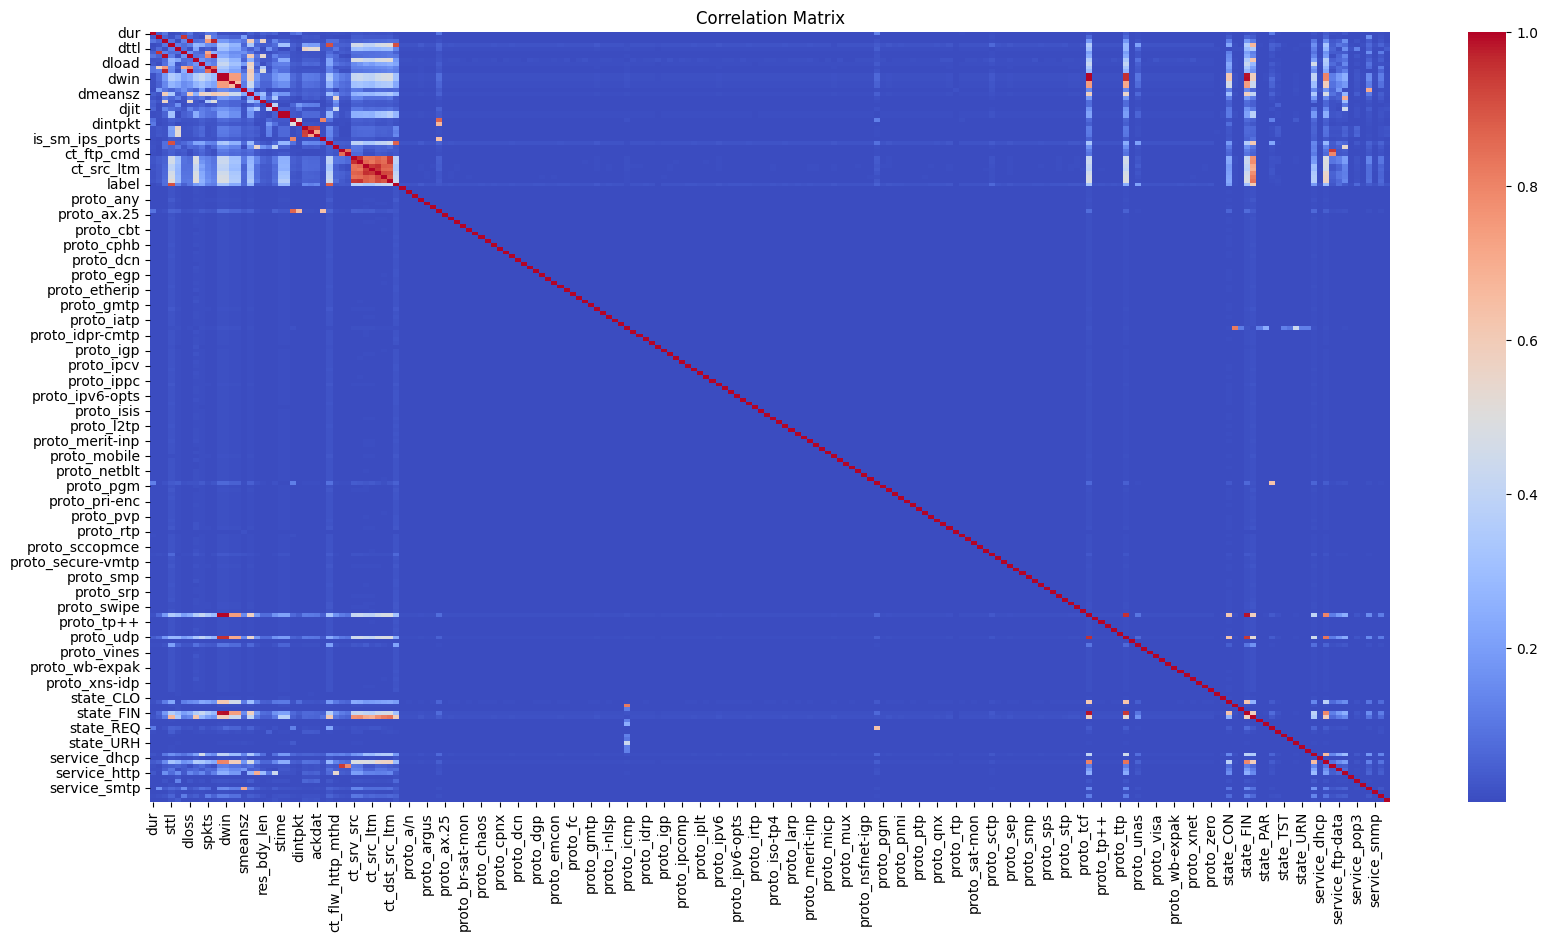

('sloss', 'sbytes')
('dloss', 'dbytes')
('dpkts', 'dbytes')
('dpkts', 'dloss')
('dwin', 'swin')
('ltime', 'stime')
('synack', 'tcprtt')
('ackdat', 'tcprtt')
('ct_state_ttl', 'sttl')
('ct_srv_dst', 'ct_srv_src')
('ct_src_ltm', 'ct_dst_ltm')
('ct_src_dport_ltm', 'ct_dst_ltm')
('ct_src_dport_ltm', 'ct_src_ltm')
('ct_dst_sport_ltm', 'ct_src_dport_ltm')
('ct_dst_src_ltm', 'ct_srv_src')
('ct_dst_src_ltm', 'ct_srv_dst')
('ct_dst_src_ltm', 'ct_src_dport_ltm')
('label', 'sttl')
('proto_tcp', 'swin')
('proto_tcp', 'dwin')
('proto_udp', 'swin')
('proto_udp', 'dwin')
('proto_udp', 'proto_tcp')
('state_FIN', 'swin')
('state_FIN', 'dwin')
('state_FIN', 'proto_tcp')
('state_FIN', 'proto_udp')
('service_ftp', 'is_ftp_login')
Pairs of highly correlated columns: [('sloss', 'sbytes'), ('dloss', 'dbytes'), ('dpkts', 'dbytes'), ('dpkts', 'dloss'), ('dwin', 'swin'), ('ltime', 'stime'), ('synack', 'tcprtt'), ('ackdat', 'tcprtt'), ('ct_state_ttl', 'sttl'), ('ct_srv_dst', 'ct_srv_src'), ('ct_src_ltm', 'ct_dst_

In [ ]:
corr_matrix = train.corr().abs()

# Step 2: Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Step 3: Identify pairs of columns with high correlation
threshold = 0.9  # Set your threshold value here (e.g., 0.8)
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col_pair = (corr_matrix.columns[i], corr_matrix.columns[j])
            high_corr_pairs.append(col_pair)
            print(col_pair)

print("Pairs of highly correlated columns:", high_corr_pairs)


In [ ]:
# Refer: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = corr_matrix.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

['dloss', 'dpkts', 'dwin', 'ltime', 'ct_srv_dst', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'proto_tcp', 'proto_udp', 'state_FIN']


In [ ]:
train.drop(['sloss', 'dpkts', 'dwin', 'ltime', 'ct_srv_dst', 'ct_src_dport_ltm', 'ct_dst_src_ltm'], axis = 1, inplace = True)
test.drop(['sloss', 'dpkts', 'dwin', 'ltime', 'ct_srv_dst', 'ct_src_dport_ltm', 'ct_dst_src_ltm'],axis = 1, inplace = True)

In [ ]:
train['network_bytes'] = train['sbytes'] + train['dbytes']
test['network_bytes'] = test['sbytes'] + test['dbytes']

In [ ]:
log1p_col = ['dur', 'sbytes', 'dbytes', 'sload', 'dload', 'spkts', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'sjit', 'djit', 'network_bytes']

def apply_log1p(data,cols):
    '''
    Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
    '''
    data.reset_index(drop=True, inplace=True)
    for col in cols:
        new_col = col + '_log1p'  # New col name
        data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
        data.drop(col, axis=1, inplace=True)  # Removing old columns
    return data

train = apply_log1p(train, log1p_col)
test = apply_log1p(test, log1p_col)

In [ ]:
train.shape, test.shape

((1524028, 38), (1016019, 38))

In [ ]:
train.select_dtypes(include=np.number).columns

Index(['sttl', 'dttl', 'dloss', 'swin', 'trans_depth', 'res_bdy_len', 'stime',
       'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports',
       'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_srv_src', 'ct_dst_ltm', 'ct_src_ltm', 'ct_dst_sport_ltm', 'label',
       'dur_log1p', 'sbytes_log1p', 'dbytes_log1p', 'sload_log1p',
       'dload_log1p', 'spkts_log1p', 'stcpb_log1p', 'dtcpb_log1p',
       'smeansz_log1p', 'dmeansz_log1p', 'sjit_log1p', 'djit_log1p',
       'network_bytes_log1p'],
      dtype='object', name='Name')

In [ ]:
cat_cols = ['proto', 'state', 'service']
num_cols = list(set(train.columns) - set(cat_cols))
print(len(num_cols))

35


In [ ]:
scaler = MinMaxScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

In [ ]:
train.shape, test.shape

((1524028, 38), (1016019, 38))

In [ ]:
categorical_feature = ['proto', 'state', 'service']

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(train[categorical_feature])

onehot_encoder_test = OneHotEncoder(sparse = False)
onehot_encoded_test = onehot_encoder_test.fit_transform(test[categorical_feature])

column_names = onehot_encoder.get_feature_names_out(input_features=categorical_feature)
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=column_names)

column_names_test = onehot_encoder_test.get_feature_names_out(input_features = categorical_feature)
onehot_encoded_df_test = pd.DataFrame(onehot_encoded_test, columns = column_names_test)

onehot_encoded_df.index = train.index
onehot_encoded_df_test.index = test.index

train = pd.concat([train.drop(categorical_feature, axis=1), onehot_encoded_df], axis=1)
test = pd.concat([test.drop(categorical_feature, axis=1), onehot_encoded_df_test], axis=1)

In [ ]:
train.shape, test.shape

((1524028, 199), (1016019, 198))

In [ ]:
print(set(train.columns) - set(test.columns))

{'proto_esp'}


In [ ]:
print(set(test.columns) - set(train.columns))

set()


In [ ]:
train.drop(list(set(train.columns) - set(test.columns)), axis = 1, inplace = True)

In [ ]:
print(train.shape)
print(test.shape)

(1524028, 198)
(1016019, 198)


In [ ]:
train.drop('dloss', axis = 1, inplace = True)
test.drop('dloss', axis = 1, inplace = True)

In [ ]:
print(train.shape)
print(test.shape)

(1524028, 197)
(1016019, 197)


In [ ]:
final_test, model_test = train_test_split(test, test_size=0.5, random_state=42, stratify=test['label'])

In [ ]:
final_test.to_csv('./final_test_dataset.csv')

In [ ]:
normal_train = train[train['label'] == 0]
normal_test_temp = model_test[model_test['label'] == 0]

In [ ]:
normal_train.shape, normal_test_temp.shape

((1331258, 197), (443753, 197))

In [ ]:
normal_train.drop('label', axis = 1, inplace = True)
normal_test_temp.drop('label', axis = 1, inplace = True)

In [ ]:
normal_val, normal_test = train_test_split(normal_test_temp, test_size = 0.5, random_state = 42)

In [ ]:
normal_train.shape, normal_val.shape, normal_test.shape

((1331258, 196), (221876, 196), (221877, 196))

In [ ]:
normal_train.shape, normal_val.shape, normal_test.shape

((1331258, 196), (221876, 196), (221877, 196))

In [ ]:
normal_train.to_csv('./normal_train_dataset.csv', index = False)
normal_val.to_csv('./normal_val_dataset.csv', index = False)
normal_test.to_csv('./normal_test_dataset.csv', index = False)

In [ ]:
df = pd.read_csv('./normal_train_dataset.csv')
df.columns

Index(['Unnamed: 0', 'sttl', 'dttl', 'swin', 'trans_depth', 'res_bdy_len',
       'stime', 'sintpkt', 'dintpkt', 'tcprtt',
       ...
       'service_ftp', 'service_ftp-data', 'service_http', 'service_irc',
       'service_pop3', 'service_radius', 'service_smtp', 'service_snmp',
       'service_ssh', 'service_ssl'],
      dtype='object', length=197)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the CSV file with data.
        """
        self.data_frame = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Assuming the data in the CSV file is already preprocessed and ready for the model
        # Convert the data to a PyTorch tensor
        sample = torch.tensor(self.data_frame.iloc[idx].values, dtype=torch.float32)

        return sample


In [ ]:
# File paths
train_file = './normal_train_dataset.csv'
val_file = './normal_val_dataset.csv'
test_file = './normal_test_dataset.csv'

# Create datasets
train_dataset = CustomDataset(csv_file=train_file)
val_dataset = CustomDataset(csv_file=val_file)
test_dataset = CustomDataset(csv_file=test_file)

# DataLoader parameters
batch_size = 1024  # Example batch size, adjust as needed
num_workers = 2  # Number of subprocesses for data loading

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)


In [ ]:
class HybridVAE_old(nn.Module):
    def __init__(self):
        super(HybridVAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)

        # Linear layers for VAE
        self.fc1 = nn.Linear(64 * 2 * 12, 256)  # Adjusted to match the LSTM output
        self.fc21 = nn.Linear(256, 16)  # Latent mean
        self.fc22 = nn.Linear(256, 16)  # Latent log variance

        # Decoder
        self.fc3 = nn.Linear(16, 256)
        self.fc4 = nn.Linear(256, 64 * 2 * 12)  # Adjusted to match the LSTM input

        # Decoder LSTM
        self.lstm_dec = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)

        # Transposed convolutional layers
        """self.deconv1 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=5, stride=4, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, output_padding=1)
        # Adjusted to expand the output to 196 features
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=1, stride=1, padding=0)"""

        self.deconv1 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=5, stride=4, padding=1, output_padding = 2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=1, stride=1, padding=0)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        #print(x.shape)
        x = x.transpose(1, 2)
        x, _ = self.lstm(x)
        #print(x.shape)
        x = x.contiguous().view(x.size(0), -1)
        #print(x.shape)

        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        #print(z.shape)

        # Calculate the expected size after the LSTM
        expected_size = 12  # This should be the output size after the pooling layers

        z = z.view(-1, expected_size, 128)  # Reshape for LSTM
        z, _ = self.lstm_dec(z)
        #print(z.shape)
        z = F.relu(self.deconv1(z.transpose(1, 2)))
        #print(z.shape)
        z = F.relu(self.deconv2(z))
        #print(z.shape)
        z = F.relu(self.deconv3(z))
        #print(z.shape)
        z = torch.sigmoid(self.deconv4(z))
        #print(z.shape)

        return z.squeeze(1)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1, 196))
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        return self.decode(z), mu, logvar

# Instantiate the model
"""model = HybridVAE()

# Example forward pass (with random data)
example_data = torch.randn(5, 196)  # Batch size of 5, 196 features
reconstructed, _, _ = model(example_data.view(-1, 1, 196))  # Reshape to match model input

print("Input shape:", example_data.shape)
print("Output shape:", reconstructed.shape)"""


'model = HybridVAE()\n\n# Example forward pass (with random data)\nexample_data = torch.randn(5, 196)  # Batch size of 5, 196 features\nreconstructed, _, _ = model(example_data.view(-1, 1, 196))  # Reshape to match model input\n\nprint("Input shape:", example_data.shape)\nprint("Output shape:", reconstructed.shape)'

In [ ]:
class HybridVAE(nn.Module):
    def __init__(self):
        super(HybridVAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dropout3 = nn.Dropout(p=0.5)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout4 = nn.Dropout(p=0.5)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)

        # Linear layers for VAE
        #self.fc1 = nn.Linear(64 * 2 * 12, 256)
        self.fc1 = nn.Linear(98 * 128, 256)
        self.fc21 = nn.Linear(256, 16)  # Latent mean
        self.fc22 = nn.Linear(256, 16)  # Latent log variance

        # Decoder
        self.fc3 = nn.Linear(16, 256)
        self.fc4 = nn.Linear(256, 64 * 2 * 12)

        # Decoder LSTM
        self.lstm_dec = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)

        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=5, stride=4, padding=1, output_padding=2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=1, stride=1, padding=0)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = F.relu(self.conv3(x))
        x = self.dropout3(x)
        x = F.relu(self.conv4(x))
        x = self.dropout4(x)
        x = self.pool(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm(x)
        x = x.contiguous().view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 12, 128)
        z, _ = self.lstm_dec(z)
        z = F.relu(self.deconv1(z.transpose(1, 2)))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        z = torch.sigmoid(self.deconv4(z))
        return z.squeeze(1)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 1, 196))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Instantiate and use the model
"""model = HybridVAE()

# Example forward pass (with random data)
example_data = torch.randn(5, 1, 196)  # Batch size of 5, 196 features
reconstructed, _, _ = model(example_data)

print("Input shape:", example_data.shape)
print("Output shape:", reconstructed.shape)"""



'model = HybridVAE()\n\n# Example forward pass (with random data)\nexample_data = torch.randn(5, 1, 196)  # Batch size of 5, 196 features\nreconstructed, _, _ = model(example_data)\n\nprint("Input shape:", example_data.shape)\nprint("Output shape:", reconstructed.shape)'

In [ ]:
model=HybridVAE()
model


HybridVAE(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout4): Dropout(p=0.5, inplace=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (fc21): Linear(in_features=256, out_features=16, bias=True)
  (fc22): Linear(in_features=256, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1536, bias=True)
  (lstm_dec): LSTM(128, 64, batch_first=True, bidirectional=True)
  (d

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# Initialize the model
model = HybridVAE().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Loss function
def vae_loss(recon_x, x, mu, log_var):
    # Adjust the input shape for BCE
    # The input x should be reshaped to match the output shape of recon_x
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 196), reduction='sum')

    # KLD remains the same
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD

In [ ]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        #print(recon_batch.shape)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(train_loader.dataset)


def validate(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            val_loss += loss.item()
    return val_loss / len(val_loader.dataset)


def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
          #print(data.shape)
          data = data.to(device)
          #print(data.shape)
          recon_batch, mu, logvar = model(data)
          #print(data.shape)
          #print(recon_batch.shape)
          loss = vae_loss(recon_batch, data, mu, logvar)
          #print(type(loss))
          if torch.isnan(loss) or torch.isinf(loss):
            print("Detected NaN or Inf loss")
            # You can take corrective actions, such as stopping training
            continue
          #print(loss.item())
          test_loss += loss.cpu().item()
          #print(type(test_loss))
    return test_loss / len(test_loader.dataset)


In [ ]:
num_epochs = 10  # Set the number of epochs
best_val_loss = float('inf')
model_save_path = './hybrid_vae_model_new.pth'

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)

    print(f"Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    # Save the model if the validation loss is improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved at Epoch {epoch}")

# Optionally, you can also save the model after all epochs are completed
# torch.save(model.state_dict(), model_save_path)
test_loss = test(model, test_loader)
print(f"Test Loss: {test_loss}")

Epoch 0, Train Loss: 14.452862158269658, Validation Loss: 10.775299406220986
Model saved at Epoch 0
Epoch 1, Train Loss: 10.646654651265475, Validation Loss: 10.51946738144983
Model saved at Epoch 1
Epoch 2, Train Loss: 10.5443034514863, Validation Loss: 10.494349889021628
Model saved at Epoch 2
Epoch 3, Train Loss: 10.514912136032704, Validation Loss: 10.455777734522886
Model saved at Epoch 3
Epoch 4, Train Loss: 10.495157901750638, Validation Loss: 10.443528243076933
Model saved at Epoch 4
Epoch 5, Train Loss: 10.48515374018527, Validation Loss: 10.435367888130646
Model saved at Epoch 5
Epoch 6, Train Loss: 10.476619369523272, Validation Loss: 10.429388610502038
Model saved at Epoch 6
Epoch 7, Train Loss: 10.471878507461316, Validation Loss: 10.44286592211838
Epoch 8, Train Loss: 10.45777003150521, Validation Loss: 10.432135147419054
Epoch 9, Train Loss: 10.439492128580167, Validation Loss: 10.405453881228986
Model saved at Epoch 9


RuntimeError: ignored

In [ ]:
device

device(type='cuda')

In [ ]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = "1"
model_save_path = './hybrid_vae_model.pth'
"""try:
  test_model = HybridVAE().to(device)
  test_model.load_state_dict(torch.load(model_save_path, map_location=device))
except Exception as e:
    # Capture and print the specific error message
    print("Error:", e)"""
model.load_state_dict(torch.load(model_save_path, map_location=device))
test_loss = test(model, test_loader)
print(f"Test Loss: {test_loss}")

In [ ]:
df = pd.read_csv('./normal_test_dataset.csv')

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
has_nan = df.isna().any().any()
has_inf = not np.isfinite(df).all().all()

print("Has NaN values:", has_nan)
print("Has Inf values:", has_inf)

Has NaN values: False
Has Inf values: False


In [ ]:
final_test_dataframe = pd.read_csv('./final_test_dataset.csv')

In [ ]:
final_test_dataframe.columns

Index(['Unnamed: 0', 'sttl', 'dttl', 'swin', 'trans_depth', 'res_bdy_len',
       'stime', 'sintpkt', 'dintpkt', 'tcprtt',
       ...
       'service_ftp', 'service_ftp-data', 'service_http', 'service_irc',
       'service_pop3', 'service_radius', 'service_smtp', 'service_snmp',
       'service_ssh', 'service_ssl'],
      dtype='object', length=198)

In [ ]:
class FinalDataset(Dataset):
    def __init__(self, csv_file):
        self.data_frame = pd.read_csv(csv_file)
        self.data_frame.drop('Unnamed: 0', axis = 1, inplace = True)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Separate features and label
        sample = torch.tensor(self.data_frame.iloc[idx, :-1].values, dtype=torch.float32)  # Assuming last column is 'label'
        label = self.data_frame.iloc[idx, -1]  # Get the label

        return sample, label


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dir = './final_test_dataset.csv'
# Load the test dataset
test_dataset = FinalDataset(dir)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Assuming your VAE model is defined and loaded
model = HybridVAE().to(device)
model.load_state_dict(torch.load("./hybrid_vae_model_new.pth"))
model.eval()

# Define a threshold for anomaly detection
threshold = 1230.0

# Function to classify data points
def classify_anomalies(data):
    reconstructed, _, _ = model(data.view(-1, 1, 196))  # Reshape to match model input
    loss = nn.functional.mse_loss(reconstructed, data.view(-1, 1, 196), reduction='none')
    loss = loss.sum(dim=[1, 2])  # Sum the loss over the features
    #return loss
    return (loss > threshold).int()  # Convert to 0 (normal) or 1 (anomalous)


# Testing and Evaluation
all_predictions = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        predictions = classify_anomalies(data.to(device))
        #print(zip(labels.numpy(), predictions.cpu().numpy()))
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())

#df = pd.DataFrame({'labels': all_labels, 'predictions': all_predictions})

# Calculate performance metrics
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='binary')
precision = precision_score(all_labels, all_predictions, average='binary')
recall = recall_score(all_labels, all_predictions, average='binary')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.793879635990701
F1 Score: 0.0004772768492091522
Precision: 0.0002387090613959706
Recall: 0.8064516129032258


In [ ]:
df[df['labels'] == 0]['predictions'].describe()


KeyError: ignored

Confusion Matrix:
 [[403273 104705]
 [     6     25]]
Area Under Curve (AUC): 0.8001652408365665


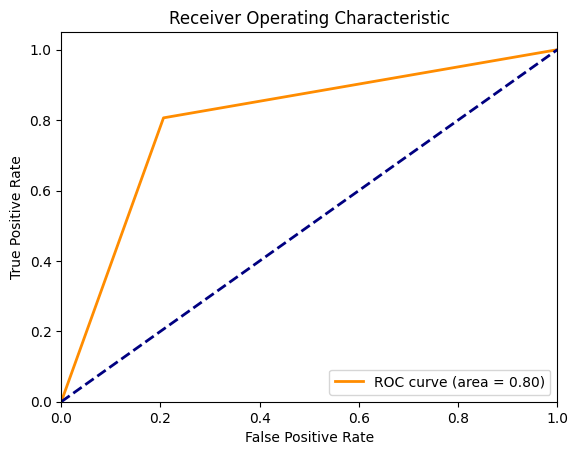

In [ ]:
# y_true = [actual values]
# y_pred = [predicted values]

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)

# Calculate AUC
roc_auc = auc(fpr, tpr)
print("Area Under Curve (AUC):", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

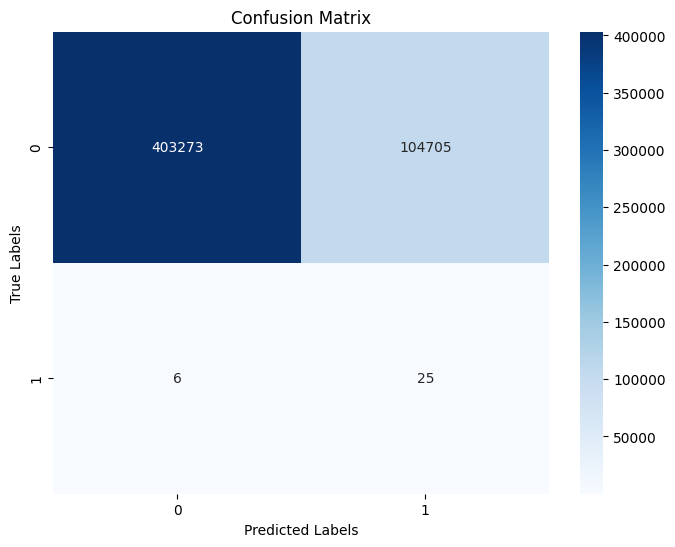

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.8 MB/s eta 0:00:00


In [ ]:
import shap

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model = HybridVAE().to(device)
model.load_state_dict(torch.load("./hybrid_vae_model_new.pth"))  # Ensure the map_location
model.eval()

# Select a subset of your data from the DataLoader
data_subset = []
for i, data in enumerate(train_loader):  # Assuming each batch returns data and labels
    data_subset.append(data)
    if i >= 25:  # Choose how many batches you want to use
        break

# Concatenate the batches and prepare the data
data_subset_tensor = torch.cat(data_subset, dim=0).to(device)  # Keeps the tensor on the device

# Create a SHAP explainer object
# Note that we are directly passing the model and a background dataset to the explainer
explainer = shap.DeepExplainer(model, data_subset_tensor)

# Calculate SHAP values
shap_values = explainer.shap_values(data_subset_tensor)

# Since we cannot plot SHAP values directly for PyTorch tensors, we convert them to NumPy arrays
shap_values_np = [sv.cpu().numpy() for sv in shap_values]

# Plot the feature importances
# Note: You might need to adjust the index for shap_values_np depending on the shape of your output
shap.summary_plot(shap_values_np[0], data_subset_tensor.cpu().numpy(), plot_type="bar")



OutOfMemoryError: ignored